In [164]:
import pandas as pd

data = pd.read_csv('datasets/top_topic_dataset.csv')

Preprocess the text data.

In [165]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, remove_stopwords, strip_numeric
import nltk
from nltk.tokenize import word_tokenize

# Download the NLTK tokenizer models
nltk.download('punkt')

# Define a preprocessing function for the text data
def preprocess_text(text):
    # Lowercase, remove tags, punctuation, numbers, and stopwords
    custom_filters = [strip_tags, strip_punctuation, strip_numeric, remove_stopwords, str.lower]
    tokens = preprocess_string(text, filters=custom_filters)
    return tokens

# def preprocess_text(text):
#     # Convert to lowercase
#     text = text.lower()
#     # Tokenize text
#     tokens = word_tokenize(text)
#     return tokens

# Apply the preprocessing function to the text column
data['processed_text'] = data['text'].apply(preprocess_text)

# Show the processed text for the first few entries
data[['text', 'processed_text']].head()


[nltk_data] Downloading package punkt to /Users/aninja/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,processed_text
0,It has been nearly three years since auto plan...,"[it, nearly, years, auto, plants, world, start..."
1,The Boston City Council Wednesday approved pro...,"[the, boston, city, council, wednesday, approv..."
2,"So far this year, 16 people have been murdered...","[so, far, year, people, murdered, boston, dorc..."
3,Recently I spent the better part of two days i...,"[recently, i, spent, better, days, conversatio..."
4,Communities across the nation are beginning th...,"[communities, nation, beginning, process, ackn..."


Train a Word2Vec model using the cleaned text.
Convert text data into numerical vectors using the trained Word2Vec model.

In [166]:
import numpy as np
from gensim.models import Word2Vec

# Training the Word2Vec model
model_word2vec = Word2Vec(sentences=data['processed_text'], vector_size=100, window=5, min_count=2, workers=4)


# Function to convert text to a vector by averaging word vectors
def document_vector(model, doc):
    # Remove out-of-vocabulary words and compute average
    return np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)

# Apply the function to each processed text
data['doc_vector'] = data['processed_text'].apply(lambda doc: document_vector(model_word2vec, doc))

# Check for any NaN entries (which can occur if texts only contain out-of-vocabulary words)
data['doc_vector'].isna().sum(), data['doc_vector'].head()


(0,
 0    [-0.092111, 0.3088583, 0.1516032, 0.1017959, 0...
 1    [-0.09525021, 0.30726716, 0.15072323, 0.100578...
 2    [-0.115438424, 0.37539804, 0.1834551, 0.120715...
 3    [-0.085984334, 0.29917264, 0.14414915, 0.09678...
 4    [-0.10459411, 0.3443299, 0.16905421, 0.1114534...
 Name: doc_vector, dtype: object)

In [168]:
# WITHOUT TUNING  AND NO NEW FEATURES
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


# Ensure all vectors are not None or NaN (handle any missing values if not handled earlier)
data = data.dropna(subset=['doc_vector'])

# Prepare features and labels
X = np.array(data['doc_vector'].tolist())  # Convert the list of vectors into a 2D array
y = data['race_discussed'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
log_reg = LogisticRegression()
naive_bayes = GaussianNB()
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train models
log_reg.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

# Predict on test data
y_pred_log = log_reg.predict(X_test)
y_pred_nb = naive_bayes.predict(X_test)
y_pred_xgb = xgboost.predict(X_test)

# Evaluate the models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))


Logistic Regression Accuracy: 0.5555555555555556
Naive Bayes Accuracy: 0.6222222222222222
XGBoost Accuracy: 0.6444444444444445


1. One-hot Encode the first_topic Column: 
- convert the categorical data from the first_topic column into a binary format where each category is represented by a different boolean column. 

2. Combine One-hot Encoded Vectors with Word2Vec Document Vectors
- concatenate  one-hot encoded vectors with the Word2Vec document vectors -> will create a single feature set that includes both text-based and categorical information.

In [169]:
# WITHOUT TUNING  WITH FEATURE ENGINEERING: FIRST TOPIC
from sklearn.preprocessing import OneHotEncoder

# One-hot encode the 'first_topic' column
encoder = OneHotEncoder(sparse=False)
topics_encoded = encoder.fit_transform(data[['first_topic']])

# Combine the one-hot encoded vectors with the Word2Vec document vectors
features_combined = np.hstack((np.array(data['doc_vector'].tolist()), topics_encoded))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_combined, data['race_discussed'], test_size=0.2, random_state=42)

# Initialize models
log_reg = LogisticRegression(C=100.0, solver='liblinear', max_iter=1000)  # was at .55 before tuning
naive_bayes = GaussianNB()
# Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.7}
xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss', colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.7, random_state=42)
# xgboost = XGBClassifier(use_label_encoder=False, eval_metric='logloss')



# Train models
log_reg.fit(X_train, y_train)
naive_bayes.fit(X_train, y_train)
xgboost.fit(X_train, y_train)

# Predict on test data
y_pred_log = log_reg.predict(X_test)
y_pred_nb = naive_bayes.predict(X_test)
y_pred_xgb = xgboost.predict(X_test)

# Evaluate the models
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_log))
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))

Logistic Regression Accuracy: 0.5777777777777777
Naive Bayes Accuracy: 0.4444444444444444
XGBoost Accuracy: 0.6


/opt/homebrew/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


TRaining Logistic Regression

In [163]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define the model
log_reg = LogisticRegression()  # 'liblinear' works well with l1 and l2 penalties.

# Create a parameter grid
param_grid_log_reg = {
    'C': np.logspace(-4, 4, 10),
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs']
}

# Setup the grid search
grid_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5, scoring='accuracy', verbose=1)

# Fit grid search
grid_log_reg.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_log_reg.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_log_reg.best_score_))

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1169, in fit
    solver = 

Best parameters: {'C': 10000.0, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation score: 0.69


In [116]:
from sklearn.model_selection import GridSearchCV


# Define the parameter grid for XGBoost
param_grid_xgb = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Setup the grid search with cross-validation
grid_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, cv=3, scoring='accuracy', verbose=1)

# Fit grid search
grid_xgb.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_xgb.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_xgb.best_score_))

Fitting 3 folds for each of 243 candidates, totalling 729 fits


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Setup the grid search
grid_search = GridSearchCV(
    estimator=XGBClassifier(),
    param_grid=param_grid,
    scoring='accuracy',  # Consider using 'roc_auc' for binary classification
    cv=3,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print(best_model)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))


Fitting 3 folds for each of 108 candidates, totalling 324 fits
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}
Best cross-validation score: 0.66


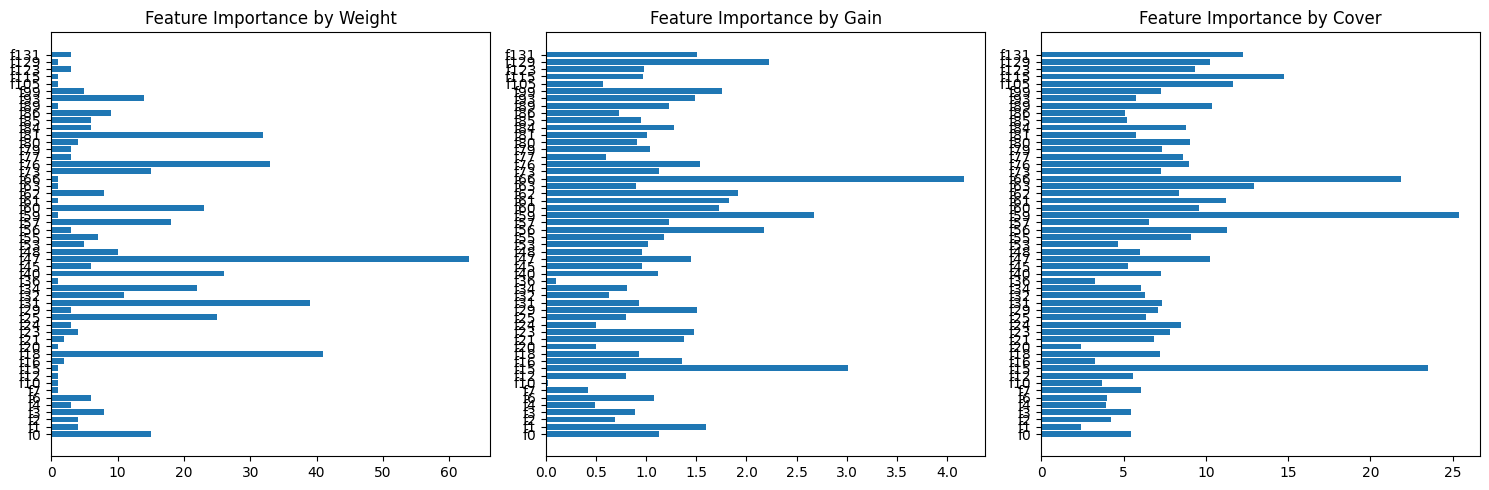

In [ ]:
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Assume X_train and y_train are already defined and preprocessed

# Create the XGBoost model with optimized parameters


# Get feature importance
importance_weight = xgboost.get_booster().get_score(importance_type='weight')
importance_gain = xgboost.get_booster().get_score(importance_type='gain')
importance_cover = xgboost.get_booster().get_score(importance_type='cover')

# Plot feature importance
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].barh(list(importance_weight.keys()), list(importance_weight.values()))
ax[0].set_title('Feature Importance by Weight')
ax[1].barh(list(importance_gain.keys()), list(importance_gain.values()))
ax[1].set_title('Feature Importance by Gain')
ax[2].barh(list(importance_cover.keys()), list(importance_cover.values()))
ax[2].set_title('Feature Importance by Cover')
plt.tight_layout()
plt.show()


In [141]:
test_sentences = [
    "Barack Obama is black",
    "I am wearing a white tie",
    "Andrew Yang is an asian man",
    "AOC is latina",
    "i have white socks on",
    "i love black people",
    "i have black shoes on",
    "i am wearing a black shirt",
    "the teacher is writing on the blackboard",
    "the chalk the teacher is using is white"
]

preprocessed_sentences = [preprocess_text(sentence) for sentence in test_sentences]
# preprocessed_sentences

# Create a list of all words in the test data for model training (emulating a previously trained scenario)
all_words = [word for sublist in preprocessed_sentences for word in sublist]
model_word2vec = Word2Vec([all_words], vector_size=100, min_count=1, window=5, workers=1)

# Function to convert text to a vector by averaging word vectors
def document_vector(model, doc):
    # Remove out-of-vocabulary words and compute average
    return np.mean([model.wv[word] for word in doc if word in model.wv], axis=0)

# Convert each preprocessed text to a vector
vectorized_sentences = [document_vector(model_word2vec, doc) for doc in preprocessed_sentences]
vectorized_sentences


[array([-5.0556269e-03,  1.1494195e-03,  1.3045343e-03,  2.7033950e-03,
        -1.1875213e-04, -3.2223321e-03, -6.9495599e-04,  3.9934153e-03,
        -3.3571655e-03, -2.2136944e-04,  2.1351618e-03, -2.1859906e-03,
        -4.6114437e-05,  3.5759592e-03,  3.9910723e-04, -4.0056696e-03,
         2.8163034e-03, -1.9929218e-03, -5.0302870e-03, -2.0003361e-03,
         9.1542915e-04,  2.3556859e-03,  1.6177930e-03,  2.5134990e-03,
        -4.9389200e-05,  1.1982351e-03,  5.0985161e-04,  6.8034763e-03,
        -9.5841190e-04, -3.5059073e-03, -4.7072675e-03, -1.3005154e-03,
        -9.8312192e-04, -4.9062422e-04,  8.4865518e-04,  3.1477357e-03,
         6.8906997e-03, -6.5669031e-03, -3.3215778e-03,  5.4449830e-03,
        -1.7739210e-03,  5.4835866e-04, -3.2491016e-04,  8.9334062e-04,
         2.7655831e-03,  2.7387587e-03, -5.5756271e-03,  1.9042450e-03,
         3.5486778e-04, -1.9402208e-03, -1.5014010e-03,  5.3161918e-04,
        -2.5316044e-03,  1.3835942e-03, -7.5643091e-04, -1.26163

In [144]:


# Load spaCy model for text vectorization
nlp = spacy.load('en_core_web_md')

# Function to generate word vectors from text
def text_to_vector(text):
    doc = nlp(text)
    return np.mean([token.vector for token in doc if not token.is_stop and not token.is_punct], axis=0, keepdims=True)

# Function to extract additional features (if used during training)
def extract_additional_features(text):
    # Placeholder: Replace with actual feature extraction logic
    return np.zeros((1, 55))

# Function to prepare the complete feature set for a list of texts
def prepare_features(texts):
    vectors = np.vstack([text_to_vector(text) for text in texts])
    additional_features = np.vstack([extract_additional_features(text) for text in texts])
    return np.hstack([vectors, additional_features])

# Example texts and labels
texts = [
    "Barack obama is black man",
    "Donald Trump is a white man",
    "Andrew Yang is an asian man",
    "AOC is latina",
    "Michelle Obama is black",
    "i love black people",
    "i am a black man"
]

# Prepare feature set for the texts
features = prepare_features(texts)

# Make predictions
log_reg_predictions = log_reg.predict(X_test)
xgb_predictions = xgboost.predict(X_test)

# Print predictions
for text, lr_pred, xgb_pred in zip(texts, log_reg_predictions, xgb_predictions):
    print(f"Text: {text}")
    print(f"Logistic Regression Prediction: {lr_pred}")
    print(f"XGBoost Prediction: {xgb_pred}\n")


Text: Barack obama is black man
Logistic Regression Prediction: 0
XGBoost Prediction: 0

Text: Donald Trump is a white man
Logistic Regression Prediction: 0
XGBoost Prediction: 0

Text: Andrew Yang is an asian man
Logistic Regression Prediction: 1
XGBoost Prediction: 0

Text: AOC is latina
Logistic Regression Prediction: 0
XGBoost Prediction: 0

Text: Michelle Obama is black
Logistic Regression Prediction: 0
XGBoost Prediction: 0

Text: i love black people
Logistic Regression Prediction: 0
XGBoost Prediction: 1

Text: i am a black man
Logistic Regression Prediction: 1
XGBoost Prediction: 1

